# Homework 2: Predicting Patient No-Shows
---
**Summer 2025 - Intructor: Joyce Yang**

**Adapted from teaching materials by Prof. Chris Volinksy Fall 2024.**

## Background

You've been hired as the manager of SHMC, a medical center in Brazil. As part of its business model, SHMC usually employs doctors on demand, meaning that doctors are asked to come only when there are appointments. However, once a doctor has been asked to come, you must pay him or her regardless of whether the patient shows up or not. You want to use data on previous appointments to figure out whether you can predict which patients are going to show up, so that you can plan better how many doctors to call.

[The data can be downloaded at this link.](https://drive.google.com/uc?download=export&id=1iM0CSzfNckc565zwpb4VpHjEVLgckLPE)


In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### Loading the data

**1. Load the data referenced by the path above into a pandas data frame. Comment on the total number of rows and columns, and show the first few rows in the dataset.**

In [141]:
from google.colab import files
uploaded = files.upload()

Saving DirectMarketing.csv to DirectMarketing (1).csv


Here's a brief summary of the features in the data:

1. PatientId - Identification of a patient.
2. AppointmentID - Identification of each appointment.
3. Gender - Male or female.
4. ScheduledDay - The day someone called or registered the appointment.
6. AppointmentDay - The day of the actual appointment, when the patient has to visit the doctor.
7. Age = How old is the patient.
8. Neighborhood - Place where the patient lives.
9. Scholarship - Whether the patient receives financial help.(0=No, 1=Yes)
10. Hypertension - Whether the patient suffers from hypertension.(0=No, 1=Yes)
11. Diabetes - Whether the patient suffers from diabetes.(0=No, 1=Yes)
12. Alcoholism - Whether the patient suffers from alcoholism.(0=No, 1=Yes)
13. Handicap - Whether the patient is handicapped (0=No, 1=Yes)
14. SMS_received - Whether 1 or more SMS messages were sent to the patient (0=No, 1=Yes)
15. No-show - Whether the patient missed the appointment.

### Exploratory Data Analysis

**2. Transform ScheduledDay and AppointmentDay into datetimes. What is the range of dates of the AppointmentDay?**

Hint: Use `pandas.to_datetime()` for this

In [144]:
df = pd.read_csv("SHMC_NoShows.csv")
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
print(df["ScheduledDay"])
print(df['AppointmentDay'])

0        2016-04-29 18:38:08+00:00
1        2016-04-29 16:08:27+00:00
2        2016-04-29 16:19:04+00:00
3        2016-04-29 17:29:31+00:00
4        2016-04-29 16:07:23+00:00
                    ...           
110522   2016-05-03 09:15:35+00:00
110523   2016-05-03 07:27:33+00:00
110524   2016-04-27 16:03:52+00:00
110525   2016-04-27 15:09:23+00:00
110526   2016-04-27 13:30:56+00:00
Name: ScheduledDay, Length: 110527, dtype: datetime64[ns, UTC]
0        2016-04-29 00:00:00+00:00
1        2016-04-29 00:00:00+00:00
2        2016-04-29 00:00:00+00:00
3        2016-04-29 00:00:00+00:00
4        2016-04-29 00:00:00+00:00
                    ...           
110522   2016-06-07 00:00:00+00:00
110523   2016-06-07 00:00:00+00:00
110524   2016-06-07 00:00:00+00:00
110525   2016-06-07 00:00:00+00:00
110526   2016-06-07 00:00:00+00:00
Name: AppointmentDay, Length: 110527, dtype: datetime64[ns, UTC]


**3. If you take a look at both dates, you will see that ScheduledDay includes a specific time with the date, but AppointmentDay doesn't. In order to compare both fields more easily, apply "normalize" to ScheduledDay (i.e., keep only the dates).**

Hint: See the [normalize](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.dt.normalize.html) method.

In [145]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.normalize()
print(df['ScheduledDay'])

0        2016-04-29 00:00:00+00:00
1        2016-04-29 00:00:00+00:00
2        2016-04-29 00:00:00+00:00
3        2016-04-29 00:00:00+00:00
4        2016-04-29 00:00:00+00:00
                    ...           
110522   2016-05-03 00:00:00+00:00
110523   2016-05-03 00:00:00+00:00
110524   2016-04-27 00:00:00+00:00
110525   2016-04-27 00:00:00+00:00
110526   2016-04-27 00:00:00+00:00
Name: ScheduledDay, Length: 110527, dtype: datetime64[ns, UTC]


**4. Create a new feature called 'TimeInAdvance' which is the difference in days between ScheduledDay and AppointmentDay. What is the longest advance time that someone scheduled an appointment?**

Hint: You may want to use `dt.days` to a datetime object to make sure this is a numeric.

In [146]:
# Create the 'TimeInAdvance' feature (difference in days)
df['TimeInAdvance'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days

# Find the longest advance time
max_advance_time = df['TimeInAdvance'].max()

print(f"The longest advance time is {max_advance_time} days.")

The longest advance time is 179 days.


**5. Explore the data set using EDA functions we have discussed in class.  Look at each feature.  Do any of them contain missing or weird values or outliers that concern you, given the feature descriptions above?  Comment on any weird values you see in any of the columns? Remove observations that contain any strange observations you have no explanation for, and report on how many rows were removed.**

In [147]:
# Basic EDA
print(df.info())
print(df.describe(include='all'))

# Check for missing values
print(df.isnull().sum())

# Check value counts for categorical variables
for col in df.select_dtypes(include='object').columns:
    print(df[col].value_counts())
    print()

# Check if ScheduledDay > AppointmentDay (weird)
weird_date_rows = df[df['ScheduledDay'] > df['AppointmentDay']]
print(f"Weird date entries: {len(weird_date_rows)}")

# Remove rows where ScheduledDay is after AppointmentDay
df = df[df['ScheduledDay'] <= df['AppointmentDay']]

# Also remove negative ages or ages over 100 if needed
df = df[(df['Age'] >= 0) & (df['Age'] <= 100)]

print(f"Rows after cleaning: {df.shape[0]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   PatientId       110527 non-null  float64            
 1   AppointmentID   110527 non-null  int64              
 2   Gender          110527 non-null  object             
 3   ScheduledDay    110527 non-null  datetime64[ns, UTC]
 4   AppointmentDay  110527 non-null  datetime64[ns, UTC]
 5   Age             110527 non-null  int64              
 6   Neighborhood    110527 non-null  object             
 7   Scholarship     110527 non-null  int64              
 8   Hypertension    110527 non-null  int64              
 9   Diabetes        110527 non-null  int64              
 10  Alcoholism      110527 non-null  int64              
 11  Handicap        110527 non-null  int64              
 12  SMS_received    110527 non-null  int64              
 13  No-show       

**6. Create a new column called "IsFemale" that is 1 if the patient is female and 0 otherwise. Also, drop the Gender column.**

In [149]:
print(df.columns)
df['IsFemale'] = (df['Gender'] == 'f').astype(int)
print(df)

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighborhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'No-show',
       'TimeInAdvance'],
      dtype='object')
           PatientId  AppointmentID Gender              ScheduledDay  \
0       2.987250e+13        5642903      F 2016-04-29 00:00:00+00:00   
1       5.589980e+14        5642503      M 2016-04-29 00:00:00+00:00   
2       4.262960e+12        5642549      F 2016-04-29 00:00:00+00:00   
3       8.679510e+11        5642828      F 2016-04-29 00:00:00+00:00   
4       8.841190e+12        5642494      F 2016-04-29 00:00:00+00:00   
...              ...            ...    ...                       ...   
110522  2.572130e+12        5651768      F 2016-05-03 00:00:00+00:00   
110523  3.596270e+12        5650093      F 2016-05-03 00:00:00+00:00   
110524  1.557660e+13        5630692      F 2016-04-27 00:00:00+00:00   
110525  9.213490e+1

**7. Do the same for the No-show variable. It should be 1 if the person didn't show and 0 otherwise.**

In [150]:
df['No-show'] = (df['No-show'] == 'Yes').astype(int)

**8. Now we explore the `Neighborhood` feature.  It is a categorical with many levels. To simplify the analysis we are going to create a new verison of `Neighborhood` by re-labelling any neighborhoods that appear LESS THAN 2000 times and give them the label Neighborhood="OTHER".  Show a table of value_counts of your *new* Neighborhood feature.**

Hint: You can use `value_counts` to check the levels and corresponding number of samples in categorical variable `Neighborhood`

In [151]:
neigh_counts = df['Neighborhood'].value_counts()
rare_neighs = neigh_counts[neigh_counts < 2000].index
df['Neighborhood'] = df['Neighborhood'].replace(rare_neighs, 'OTHER')

# Show value counts
print(df['Neighborhood'].value_counts())


Neighborhood
OTHER                43876
JARDIM CAMBURI        7717
MARIA ORTIZ           5804
RESISTÊNCIA           4430
JARDIM DA PENHA       3877
ITARARÉ               3514
CENTRO                3334
SANTA MARTHA          3131
TABUAZEIRO            3131
JESUS DE NAZARETH     2853
BONFIM                2773
SANTO ANTÔNIO         2744
SANTO ANDRÉ           2571
CARATOÍRA             2565
JABOUR                2509
SÃO PEDRO             2448
ILHA DO PRÍNCIPE      2266
NOVA PALESTINA        2264
ANDORINHAS            2258
DA PENHA              2217
ROMÃO                 2214
GURIGICA              2018
Name: count, dtype: int64


**9. Create dummy variables for your new Neighborhood feature, add the dummies to your data frame, and then drop the original Neighborhood column from the data frame. Print a `head()` of your new data frame.**

In [152]:
df = pd.get_dummies(df, columns=['Neighborhood'], drop_first=True)
print(df.head())


      PatientId  AppointmentID Gender              ScheduledDay  \
0  2.987250e+13        5642903      F 2016-04-29 00:00:00+00:00   
1  5.589980e+14        5642503      M 2016-04-29 00:00:00+00:00   
2  4.262960e+12        5642549      F 2016-04-29 00:00:00+00:00   
3  8.679510e+11        5642828      F 2016-04-29 00:00:00+00:00   
4  8.841190e+12        5642494      F 2016-04-29 00:00:00+00:00   

             AppointmentDay  Age  Scholarship  Hypertension  Diabetes  \
0 2016-04-29 00:00:00+00:00   62            0             1         0   
1 2016-04-29 00:00:00+00:00   56            0             0         0   
2 2016-04-29 00:00:00+00:00   62            0             0         0   
3 2016-04-29 00:00:00+00:00    8            0             0         0   
4 2016-04-29 00:00:00+00:00   56            0             1         1   

   Alcoholism  ...  Neighborhood_MARIA ORTIZ  Neighborhood_NOVA PALESTINA  \
0           0  ...                     False                        False   
1   

**10. There are many patients that have made more than one appointment. This data set contains multiple observations per person, so we can use their past appointments as features in predicting whether the current appointment will be a no-show.**

**For example, the fact that a patient has failed to show up in the past may be predictive of the patient not showing up in the future. We want to create a variable that calculates the number of no_shows BEFORE the current appointment.**

**Create a new column called "PreviousNoShows" that for each appointment includes the number of *previous* appointments to which the patient did not show. For example, if the person did not show to the first meeting, PreviousNoShows should be 0 for the first appointment and 1 for the second one (if there is any). (We have provided sample code for this part below, but take a look at it to see if it makes sense to you, and edit to use your data frame name).**

**Now, create a line plot showing - for each value of PreviousNoShows, what is the percent No-Shows for the current appointment.  Does there seem to be a relationship? That is, does the number of PREVIOUS no-shows seem to be predictive of a no-show for the CURRENT appointment?  Comment.**

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Scholarship', 'Hypertension', 'Diabetes',
       'Alcoholism', 'Handicap', 'SMS_received', 'No-show', 'TimeInAdvance',
       'IsFemale', 'Neighborhood_BONFIM', 'Neighborhood_CARATOÍRA',
       'Neighborhood_CENTRO', 'Neighborhood_DA PENHA', 'Neighborhood_GURIGICA',
       'Neighborhood_ILHA DO PRÍNCIPE', 'Neighborhood_ITARARÉ',
       'Neighborhood_JABOUR', 'Neighborhood_JARDIM CAMBURI',
       'Neighborhood_JARDIM DA PENHA', 'Neighborhood_JESUS DE NAZARETH',
       'Neighborhood_MARIA ORTIZ', 'Neighborhood_NOVA PALESTINA',
       'Neighborhood_OTHER', 'Neighborhood_RESISTÊNCIA', 'Neighborhood_ROMÃO',
       'Neighborhood_SANTA MARTHA', 'Neighborhood_SANTO ANDRÉ',
       'Neighborhood_SANTO ANTÔNIO', 'Neighborhood_SÃO PEDRO',
       'Neighborhood_TABUAZEIRO', 'NoShowBinary', 'PreviousNoShows'],
      dtype='object')


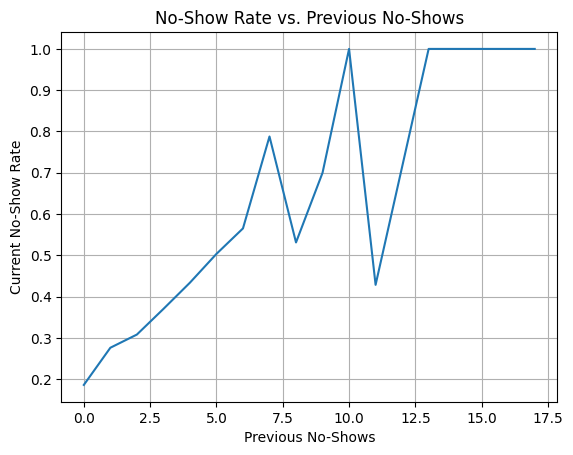

['No-show']

In [164]:
## sample code for calculating PreviousNoShows- make sure to replace "df" with your data frame name

# df = df.sort_values(['PatientId', 'ScheduledDay'])
# df['PreviousNoShows'] = df.groupby(['PatientId'])['No-show'].cumsum()- noshows
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df = df.sort_values(by=['PatientId', 'AppointmentDay'])

# Convert 'No-show' to binary (1 for No-show, 0 for showed up)
df['NoShowBinary'] = df['No-show'].map({'Yes': 1, 'No': 0})

# Group by patient and calculate cumulative no-shows, then shift by 1 to get only previous ones
df['PreviousNoShows'] = df.groupby('PatientId')['NoShowBinary'].cumsum().shift(fill_value=0)
print(df.columns)
df['PreviousNoShows'] = df.groupby('PatientId')['No-show'].cumsum() - df['No-show']

# Plot relationship
import seaborn as sns
import matplotlib.pyplot as plt

grouped = df.groupby('PreviousNoShows')['No-show'].mean()
grouped.plot(kind='line')
plt.xlabel('Previous No-Shows')
plt.ylabel('Current No-Show Rate')
plt.title('No-Show Rate vs. Previous No-Shows')
plt.grid()
plt.show()
['No-show']


### Predictive modeling using Trees

**11. Let's drop the columns we won't be needing. Drop PatientId, AppointmentID, ScheduledDay, AppointmentDay.**



In [156]:
print(df.columns)
df_cleaned = df.drop(columns=['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay'])

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Scholarship', 'Hypertension', 'Diabetes',
       'Alcoholism', 'Handicap', 'SMS_received', 'No-show', 'TimeInAdvance',
       'IsFemale', 'Neighborhood_BONFIM', 'Neighborhood_CARATOÍRA',
       'Neighborhood_CENTRO', 'Neighborhood_DA PENHA', 'Neighborhood_GURIGICA',
       'Neighborhood_ILHA DO PRÍNCIPE', 'Neighborhood_ITARARÉ',
       'Neighborhood_JABOUR', 'Neighborhood_JARDIM CAMBURI',
       'Neighborhood_JARDIM DA PENHA', 'Neighborhood_JESUS DE NAZARETH',
       'Neighborhood_MARIA ORTIZ', 'Neighborhood_NOVA PALESTINA',
       'Neighborhood_OTHER', 'Neighborhood_RESISTÊNCIA', 'Neighborhood_ROMÃO',
       'Neighborhood_SANTA MARTHA', 'Neighborhood_SANTO ANDRÉ',
       'Neighborhood_SANTO ANTÔNIO', 'Neighborhood_SÃO PEDRO',
       'Neighborhood_TABUAZEIRO', 'NoShowBinary', 'PreviousNoShows'],
      dtype='object')



**12. Build a model to predict No-Show using a DecisionTreeClassifier. First, split the data into training and test (80/20) - using `random_state=99`.  Using max_depth=3, fit the DecisionTreeClassifier to the training set and report the accuracy on the test set.**


In [173]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


In [174]:
# Encode categorical variables using one-hot encoding
df_encoded = pd.get_dummies(df_cleaned, columns=['Gender'], drop_first=True)

# Drop target column and split
X = df_encoded.drop(columns=['No-show'])
y = df_encoded['No-show']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# Train model
model = DecisionTreeClassifier(max_depth=3, random_state=99)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)

print(f"F1 Score (max_depth=3): {f1:.4f}")

F1 Score (max_depth=3): 0.0136


**13: Plot the tree.  What are the rules for the path that has the HIGHEST probability of NO-SHOW? Comment on these rules, do they make sense, are they intuitive?**

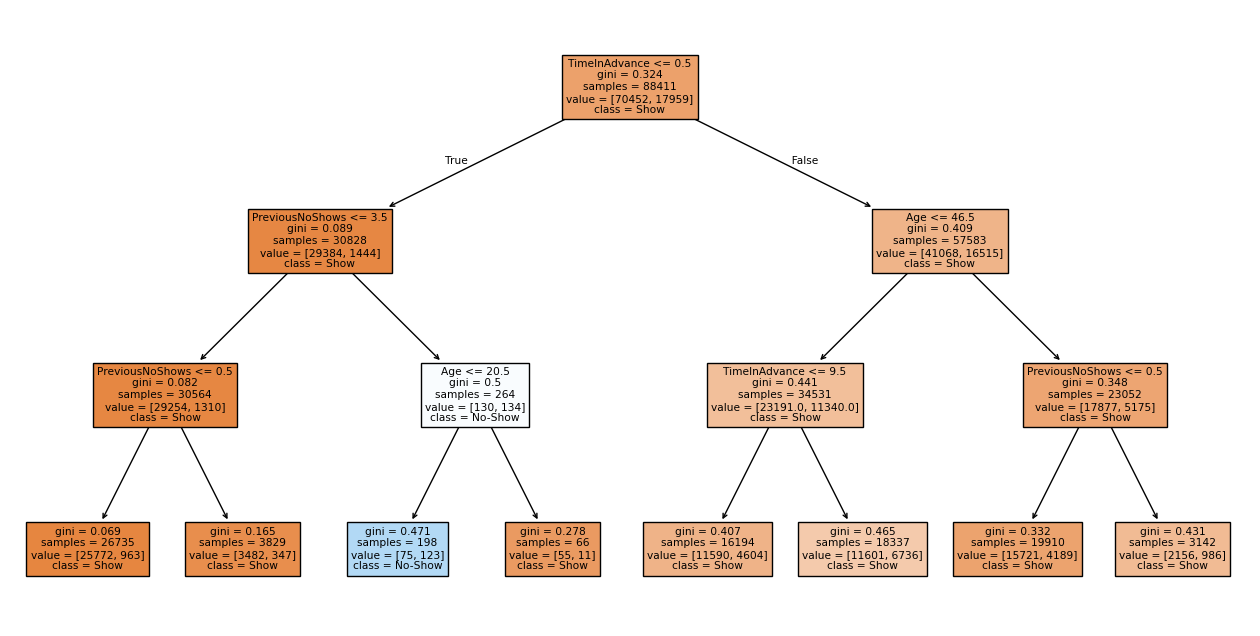

In [175]:
from sklearn.tree import plot_tree

plt.figure(figsize=(16, 8))
plot_tree(model, feature_names=X.columns, class_names=['Show', 'No-Show'], filled=True)
plt.show()


**14. Now we will calculate the optimal tree depth.**
- Create a for-loop that cycles over all `max_depth` values between 2 and 50
- in each iteration fit the model to the training set and calculate the F-measure on the test set (using `f1_score`) and store the F_measure in a list
- print out the f1_score at each iteration
- make a plot of max_depth vs. `f1_score`
- Select an optimal tree depth based on the plot (look for where the F-measure flattens out)

*Don't be bothered by cross-validation concept. To make this homework simple, we only train on the training dataset and pick the optimal parameters based on the evaluation of testing dataset.*

Depth: 2, F1 Score: 0.0136
Depth: 3, F1 Score: 0.0136
Depth: 4, F1 Score: 0.0127
Depth: 5, F1 Score: 0.0759
Depth: 6, F1 Score: 0.0874
Depth: 7, F1 Score: 0.0914
Depth: 8, F1 Score: 0.1220
Depth: 9, F1 Score: 0.1262
Depth: 10, F1 Score: 0.1393
Depth: 11, F1 Score: 0.1555
Depth: 12, F1 Score: 0.1525
Depth: 13, F1 Score: 0.1676
Depth: 14, F1 Score: 0.1828
Depth: 15, F1 Score: 0.1945
Depth: 16, F1 Score: 0.2006
Depth: 17, F1 Score: 0.2070
Depth: 18, F1 Score: 0.2198
Depth: 19, F1 Score: 0.2225
Depth: 20, F1 Score: 0.2370
Depth: 21, F1 Score: 0.2485
Depth: 22, F1 Score: 0.2569
Depth: 23, F1 Score: 0.2599
Depth: 24, F1 Score: 0.2799
Depth: 25, F1 Score: 0.2786
Depth: 26, F1 Score: 0.2807
Depth: 27, F1 Score: 0.2921
Depth: 28, F1 Score: 0.2928
Depth: 29, F1 Score: 0.2967
Depth: 30, F1 Score: 0.2987
Depth: 31, F1 Score: 0.2995
Depth: 32, F1 Score: 0.3037
Depth: 33, F1 Score: 0.3037
Depth: 34, F1 Score: 0.3057
Depth: 35, F1 Score: 0.3074
Depth: 36, F1 Score: 0.3069
Depth: 37, F1 Score: 0.3055


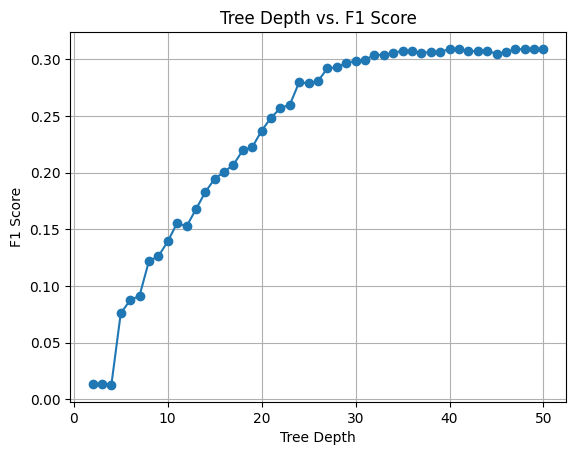

In [169]:
depths = list(range(2, 51))
f1_scores = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=99)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    score = f1_score(y_test, preds)
    f1_scores.append(score)
    print(f"Depth: {d}, F1 Score: {score:.4f}")

# Plot
plt.plot(depths, f1_scores, marker='o')
plt.xlabel('Tree Depth')
plt.ylabel('F1 Score')
plt.title('Tree Depth vs. F1 Score')
plt.grid()
plt.show()

**15.  Fit the tree model (again) using the optimal depth and call this `final_model`.  Create the 2x2 confusion matrix using the predictions on the test set, vs the true values of the test set (make sure your confusion matrix is labelled). Calculate precision and recall (either directly from the 2x2 matrix, or by using the functions `precision_score` and `recall_score`)**

In [170]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Assume optimal depth is selected from plot above
final_model = DecisionTreeClassifier(max_depth=48, random_state=99)
final_model.fit(X_train, y_train)
final_preds = final_model.predict(X_test)

cm = confusion_matrix(y_test, final_preds)
print("Confusion Matrix:\n", cm)

# Calculate precision and recall
precision = precision_score(y_test, final_preds)
recall = recall_score(y_test, final_preds)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Confusion Matrix:
 [[15232  2519]
 [ 3097  1255]]
Precision: 0.3325
Recall: 0.2884


**16. Calculate the feature importance values for the features in `final_model`.  Comment on what the most important features are in estimating no-shows (and what isn't).  Are you surprised at what was and what was not important?  Comment on how you might you deal with this knowledge in making your office more efficient.**

In [171]:
feature_importances = pd.Series(final_model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print(feature_importances)


TimeInAdvance                     0.329216
Age                               0.285347
Gender_M                          0.048751
Neighborhood_OTHER                0.030614
PreviousNoShows                   0.029786
Scholarship                       0.024962
Hypertension                      0.024475
SMS_received                      0.020514
Diabetes                          0.015310
Neighborhood_JARDIM CAMBURI       0.012433
Neighborhood_RESISTÊNCIA          0.011613
Neighborhood_CENTRO               0.010745
Neighborhood_TABUAZEIRO           0.009953
Neighborhood_CARATOÍRA            0.009800
Neighborhood_BONFIM               0.009782
Neighborhood_MARIA ORTIZ          0.009733
Handicap                          0.009251
Neighborhood_SANTO ANTÔNIO        0.009010
Neighborhood_JABOUR               0.008750
Neighborhood_SANTA MARTHA         0.008563
Neighborhood_SÃO PEDRO            0.008398
Neighborhood_JARDIM DA PENHA      0.008366
Alcoholism                        0.008170
Neighborhoo

**17. The F_measure above was calculated using a threshold of 0.5 (this is the default in the tree fitting function).  As we discussed in class, changing the threshold will have an effect on precision and recall.  Plot a histogram of the predicted probabilities that come out of your final model (using `.predict_proba() )`.  Using what you learn from the histogram, select a different threshold for labelling a patient as a No-show. Calculate precision, recall, and F-measure for your threshold and compare it to the default threshold of 0.5.  Comment on the tradeoff between the two thresholds, what are the pros and cons?  Which threshold would you choose?**

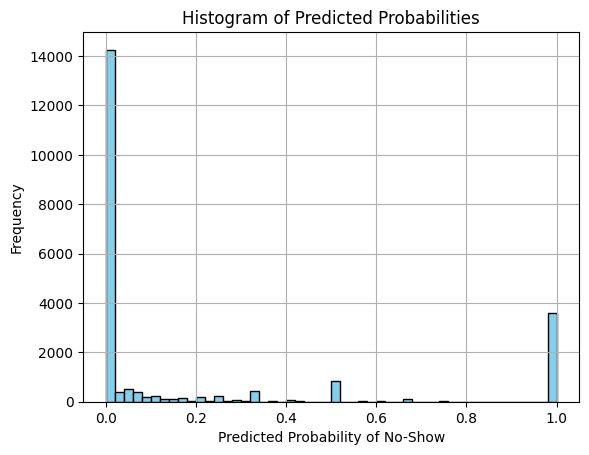

Threshold = 0.5 → Precision: 0.3206, Recall: 0.3405, F1: 0.3303
Threshold = 0.3 → Precision: 0.3128, Recall: 0.3739, F1: 0.3406


In [172]:
probs = final_model.predict_proba(X_test)[:, 1]
plt.hist(probs, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Predicted Probability of No-Show')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.grid(True)
plt.show()
# Default threshold (0.5)
default_preds = (probs >= 0.5).astype(int)
precision_default = precision_score(y_test, default_preds)
recall_default = recall_score(y_test, default_preds)
f1_default = f1_score(y_test, default_preds)

# New threshold (0.3)
new_threshold = 0.3
new_preds = (probs >= new_threshold).astype(int)
precision_new = precision_score(y_test, new_preds)
recall_new = recall_score(y_test, new_preds)
f1_new = f1_score(y_test, new_preds)

print(f"Threshold = 0.5 → Precision: {precision_default:.4f}, Recall: {recall_default:.4f}, F1: {f1_default:.4f}")
print(f"Threshold = 0.3 → Precision: {precision_new:.4f}, Recall: {recall_new:.4f}, F1: {f1_new:.4f}")